In [50]:
import maintsim

import math
import time

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
from scipy import stats

### Single machine production, no degradation

In [2]:
system1 = maintsim.System(process_times=[5])
system1.simulate(sim_time=100)

Simulation complete in 0.08s

  Units produced:      20
  System availability: 100.00%



In [3]:
system1.production_data.head()

,time,M0 production,M0 throughput
0,0.0,0.0,NaN
1,1.0,0.0,0.0
2,2.0,0.0,0.0
3,3.0,0.0,0.0
4,4.0,0.0,0.0


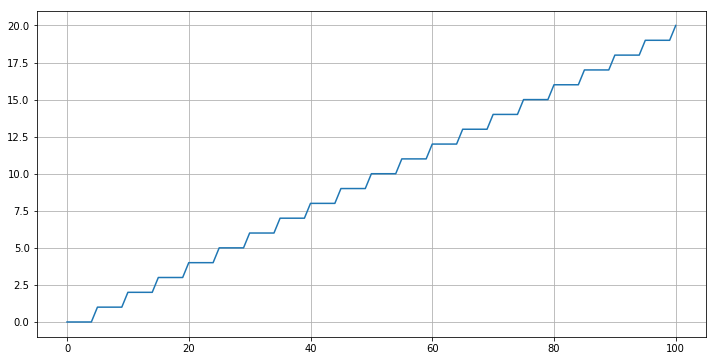

In [9]:
plt.plot(system1.production_data['M0 production'])
plt.grid()
plt.show()

### Single machine production with degradation

In [5]:
system2 = maintsim.System(process_times=[5],
                          failure_mode='degradation',
                          failure_params=[0.2],
                          repair_params={'CM':stats.randint(10,20)})
system2.simulate(sim_time=100)

Simulation complete in 0.11s

  Units produced:      17
  System availability: 88.00%



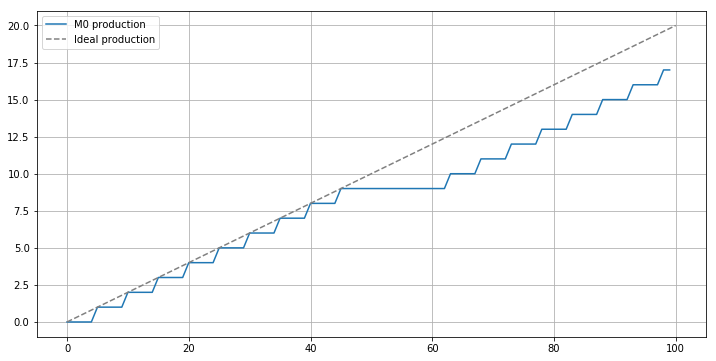

In [10]:
plt.plot(system2.production_data['M0 production'], 
         label='M0 production')

# ideal production: production volume with no downtime
ideal_production = system2.sim_time / system2.machines[0].process_time
plt.plot([0, system2.sim_time], [0, ideal_production], '--', c='gray',
         label='Ideal production')

plt.legend()
plt.grid()
plt.show()

### Three machine serial line production with degradation and condition-based maintenance

In [11]:
system3 = maintsim.System(process_times=[3, 5, 4],
                          failure_mode='degradation',
                          failure_params=[0.25, 0.1, 0.2],
                          maintenance_policy='CBM',
                          maintenance_params={'CBM threshold': [7, 6, 8]},
                          repair_params={'CM': stats.randint(20,30),
                                         'CBM': stats.randint(10,20)},
                          maintenance_capacity=3)
system3.simulate(warmup_time=50, sim_time=200)

Simulation complete in 0.51s

  Units produced:      25
  System availability: 73.50%



In [28]:
mask = system3.maintenance_data['time'] >= 0
system3.maintenance_data[mask]

,time,machine,type,activity,duration
2,2,0,CBM,repair,11
3,5,1,CBM,failure,NA
4,6,2,CBM,repair,12
5,15,1,CBM,repair,10
6,23,0,CBM,failure,21
7,38,0,CBM,repair,15
8,51,2,CBM,failure,45
9,65,2,CBM,repair,14
10,66,0,CBM,failure,28
11,76,0,CBM,repair,10


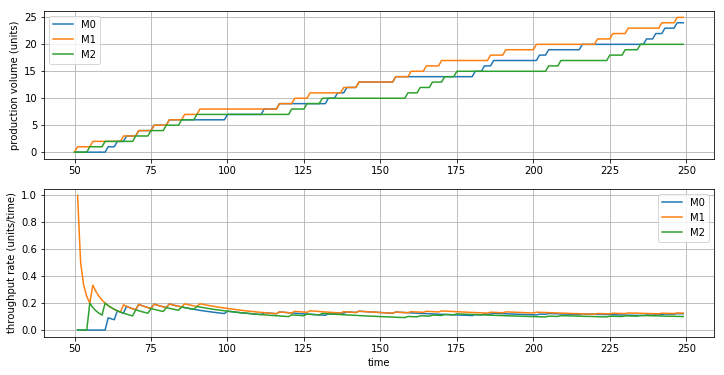

In [54]:
production_data = system3.production_data[system3.production_data['time'] >= 0]

ax1 = plt.subplot(211)
for m in range(system3.M):
    plt.plot(production_data['M{} production'.format(m)], label='M{}'.format(m))
plt.ylabel('production volume (units)')
plt.legend()
plt.grid()    
    
ax2 = plt.subplot(212, sharex=ax1)
for m in range(system3.M):
    plt.plot(production_data['M{} throughput'.format(m)], label='M{}'.format(m))
plt.xlabel('time')
plt.ylabel('throughput rate (units/time)')
plt.legend()
plt.grid()
plt.show()

### Replicate three machine production volume

In [46]:
reps = 100
production = []

start = time.time()
for r in range(reps):
    system3.simulate(warmup_time=50, sim_time=200, verbose=False)
    production.append(system3.machines[-1].parts_made)
print('{} replications completed in {:.2f}s'.format(reps, time.time()-start))

100 replications completed in 47.71s


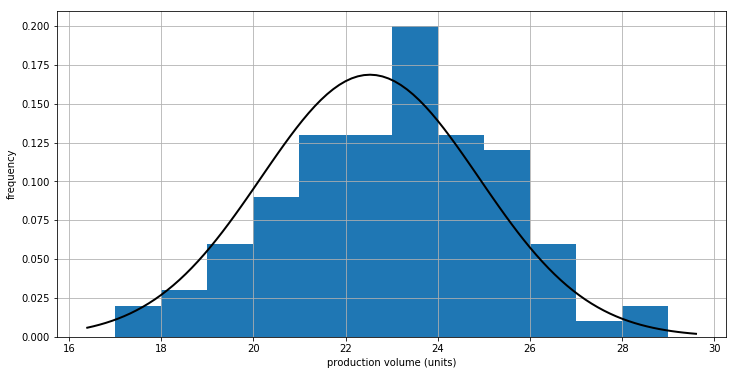

In [52]:
bins = np.arange(min(production), max(production)+1)
plt.hist(production, density=True, bins=bins)

mu, std = stats.norm.fit(production)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('production volume (units)')
plt.ylabel('frequency')
plt.grid()
plt.show()